In [1]:
import datetime
import numpy as np
from utils.data_processing import (
    load_dataset, 
    save_dataset,
    remove_duplicates_and_empty_rows,
    check_if_column_is_unique_per_row,
    predict_missing_values_with_linear_regression,
    get_outliers_IRQ,
    get_distinct_rows_from_dataframes,
    BRONZE_PATH,
    SILVER_PATH,
    GROUP_FILENAME,
    POSTS_FILENAME
)
from utils.data_visualization import (
    analyse_categorical_features,
    analyse_numerical_features,
    analyse_numerical_features_per_category,
    plot_correlation_matrices,
    plot_scatter_graph
)

In [2]:
group_df_raw = load_dataset(filepath=BRONZE_PATH + GROUP_FILENAME)
posts_df_raw = load_dataset(filepath=BRONZE_PATH + POSTS_FILENAME)

# Exploratory Data Analysis:

In this notebook analysis of initial (_bronze_ layer) datasets will be conducted. Based on the research done, necessary transformations
will be defined to load data to _silver_ layer.

Main purposes of the preformed EDA:
1. Define proper type for each feature.
2. Clean datasets if there exists duplicated or completely empty rows.
3. Check dependencies between two datasets.
4. Investigate distribution, outliers and empty values for categorical features.
5. Investigate distribution, outliers and empty values for numerical features.
6. Explore behaviour of numerical features within category.
7. Explore correlations between numerical features. 
9. Define strategies of empty values handling for each feature.
10. Investigate and define ways of outliers handling.
11. Common scence questions.

## 1. Feature types:

### Investigation:

Sample values:

In [3]:
group_df_raw

,post_id,group_name
0,1,groupE
1,2,groupC
2,3,groupC
3,4,groupD
4,5,groupE
...,...,...
19995,19996,groupB
19996,19997,groupD
19997,19998,groupA
19998,19999,groupC


In [4]:
posts_df_raw

,post_id,post_date,post_type,reach,click,likes,comments,share,reaction
0,1,2024-01-10,article,848706,67896,59409.0,241,37,384
1,2,2024-02-06,short,7927,476,317.0,284,72,16
2,3,2024-01-18,short,8326,666,167.0,252,32,50
3,4,2024-02-11,short,4039,162,40.0,149,87,487
4,5,2024-03-13,promo,496568,39725,14897.0,57,7,271
...,...,...,...,...,...,...,...,...,...
19995,19996,2024-01-01,article,844,51,68.0,71,100,257
19996,19997,2024-01-14,short,4139,331,83.0,275,70,295
19997,19998,2024-01-15,article,457,41,18.0,155,71,281
19998,19999,2024-01-03,short,92,6,7.0,156,40,379


List of features and their types:

In [5]:
group_df_raw.dtypes

post_id        int64
group_name    object
dtype: object

In [6]:
posts_df_raw.dtypes

post_id        int64
post_date     object
post_type     object
reach          int64
click          int64
likes        float64
comments       int64
share          int64
reaction       int64
dtype: object

### Conclusion:

According to the information above, following schemas will be applied to the datasets for proper types handling:

In [7]:
group_df_schema = {
    "post_id" : int,
    "group_name" : str
}

In [8]:
posts_df_schema = {
    "post_id" : int,
    "post_date" : object,
    "post_type" : str,
    "reach" : int,
    "click" : int,
    "likes" : float,
    "comments" : int,
    "share" : int,
    "reaction" : int
}

Reloading datasets with proper data types applied:

In [9]:
group_df_converted_types = load_dataset(BRONZE_PATH + GROUP_FILENAME, dtype=group_df_schema)
posts_df_converted_types = load_dataset(BRONZE_PATH + POSTS_FILENAME, dtype=posts_df_schema, parse_dates=["post_date"], date_format="%Y-%m-%d")

## 2. Empty and duplicated rows:

### Investigation:

Removing completely empty and duplicated rows, and cheking how many rows were removed

In [10]:
group_df_cleaned_rows = remove_duplicates_and_empty_rows(group_df_converted_types, "GROUP_DF")
posts_df_cleaned_rows = remove_duplicates_and_empty_rows(posts_df_converted_types, "POSTS_DF")

For dataset 'GROUP_DF':
Number of duplicated rows: 0.
Number of empty rows: 0. 

For dataset 'POSTS_DF':
Number of duplicated rows: 0.
Number of empty rows: 0. 



### Conclusion:

There are no duplicates or empty rows, what cannot but please.

## 3. Dependencies between datasets:

### Investigation:

Checking whether `post_id` is a PK for both datasets

In [11]:
check_if_column_is_unique_per_row(group_df_cleaned_rows, "post_id")

True

In [12]:
check_if_column_is_unique_per_row(posts_df_cleaned_rows, "post_id")

True

Comparing values of `post_id` from each dataset

In [13]:
group_post_ids = sorted(group_df_cleaned_rows["post_id"].to_list())
posts_post_ids = sorted(posts_df_cleaned_rows["post_id"].to_list())

group_post_ids == posts_post_ids

True

### Conclusion:

Column `post_id` is unique per row for each dataset and can be treated as PK for each table. Moreover relation between two enteties is one-to-one.

## 4. Categorical features analysis:

Displaying counts and number of empty values for categorical features

Counts for group_name:
group_name
groupD    4074
groupE    4064
groupC    4027
groupB    3952
groupA    3883
Name: count, dtype: int64



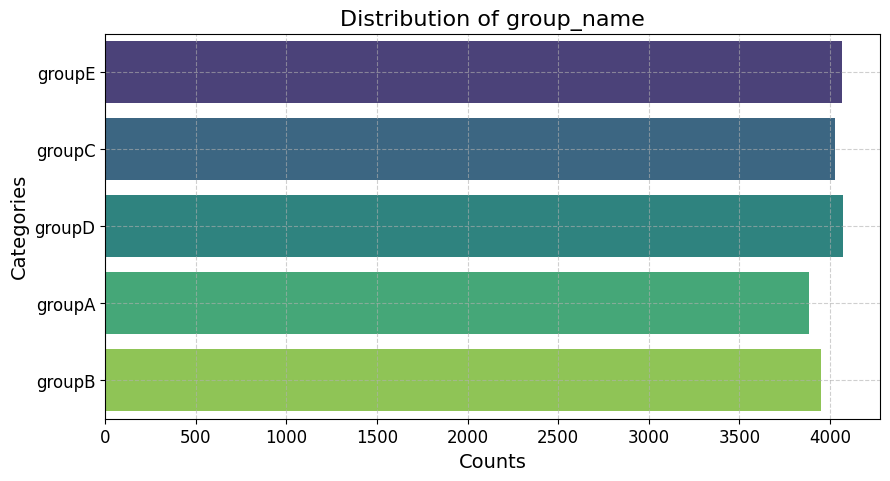

No missing values in group_name.



In [14]:
analyse_categorical_features(group_df_cleaned_rows)

Counts for post_type:
post_type
short      6832
promo      6649
article    6519
Name: count, dtype: int64



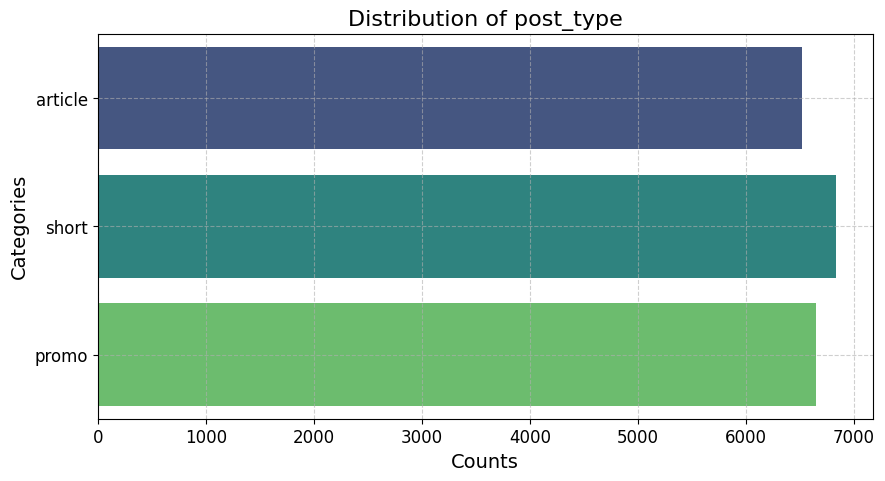

No missing values in post_type.



In [15]:
analyse_categorical_features(posts_df_cleaned_rows)

### Conclusion:

There are no missing values in categorical features in both datasets. Number of rows with same categorical feature are approximately the same.

## 5. Numerical features analysis:

Displaying counts and number of empty values for numerical features (excluding `post_id`)

In [16]:
analyse_numerical_features(group_df_cleaned_rows, cols_to_remove=["post_id"])

No numerical features exists in dataset.


Descriptive Statistics for reach:
count     20000.000000
mean     104710.528550
std      239586.822023
min          50.000000
25%         924.000000
50%        3864.000000
75%        8796.000000
max      999755.000000
Name: reach, dtype: float64




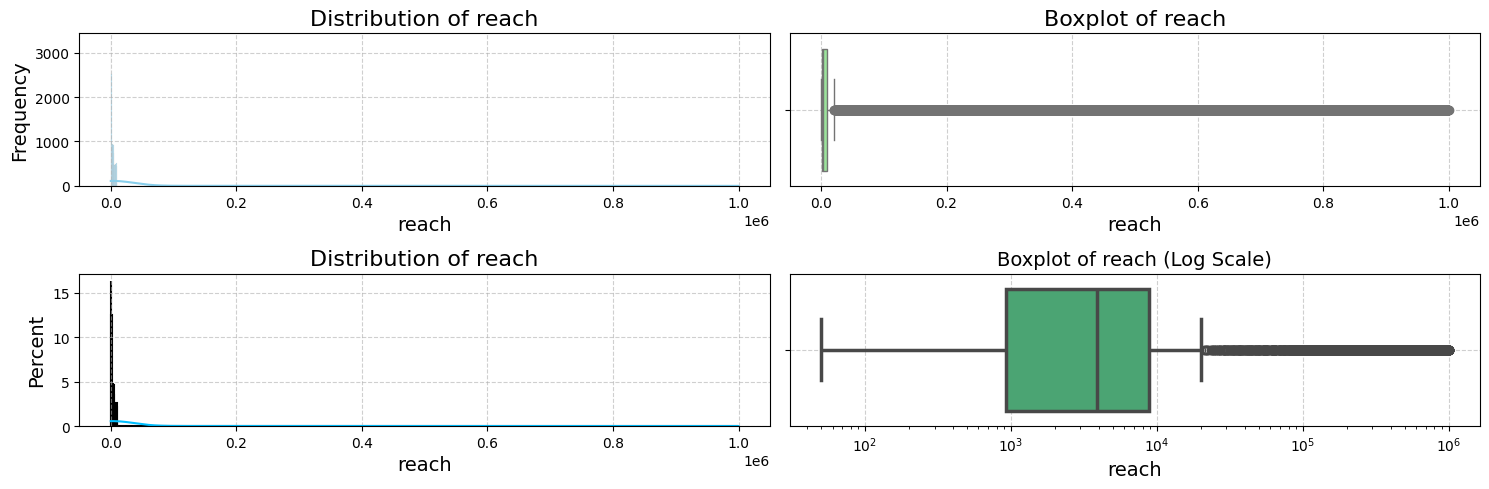

No missing values in reach.

Descriptive Statistics for click:
count    20000.000000
mean      5211.614550
std      14545.544333
min          0.000000
25%         30.000000
50%        135.000000
75%        493.000000
max      99923.000000
Name: click, dtype: float64




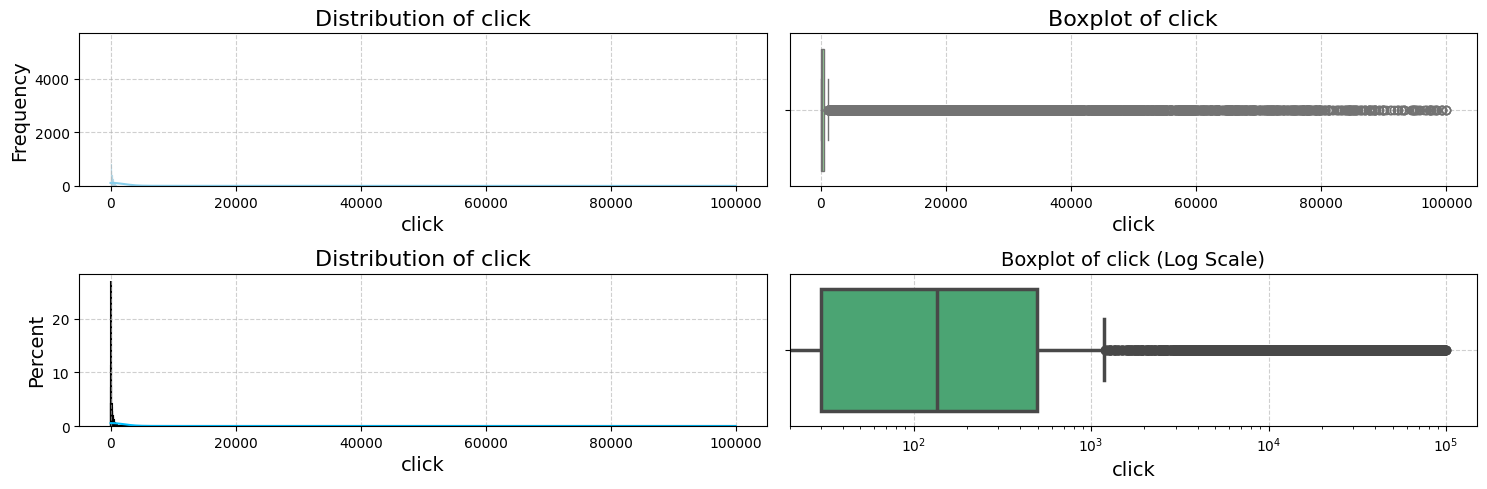

No missing values in click.

Descriptive Statistics for likes:
count    19963.000000
mean      5262.187296
std      14606.830061
min          0.000000
25%         28.000000
50%        130.000000
75%        492.500000
max      99869.000000
Name: likes, dtype: float64




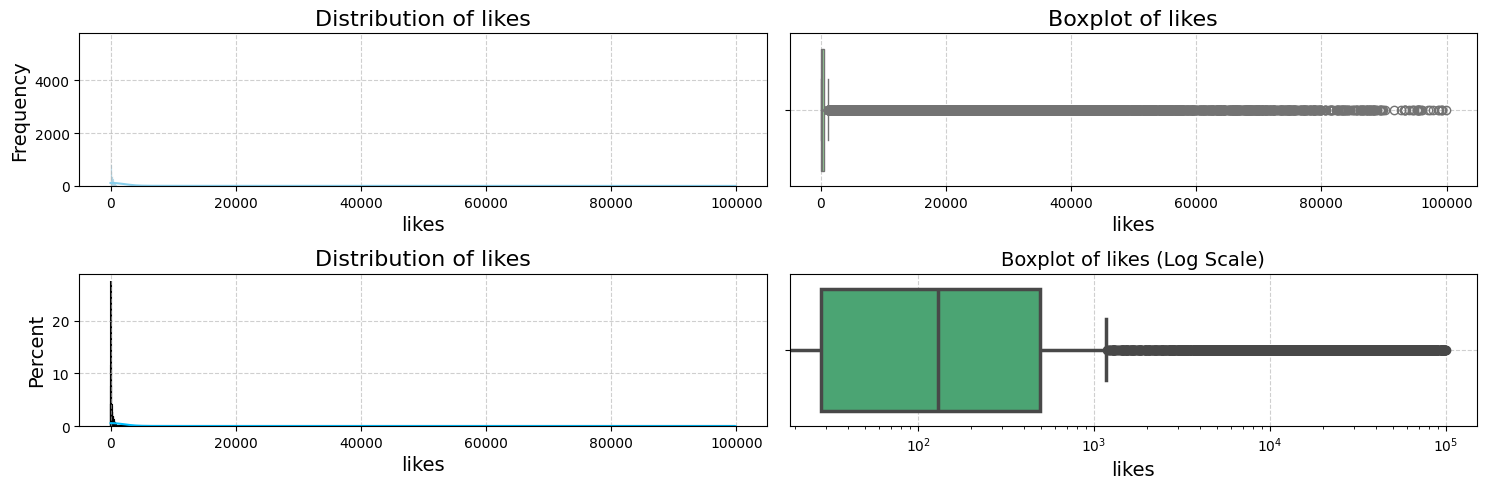

Missing values in likes: 37.

Descriptive Statistics for comments:
count    20000.000000
mean       150.252250
std         86.201864
min          0.000000
25%         76.000000
50%        151.000000
75%        224.000000
max        300.000000
Name: comments, dtype: float64




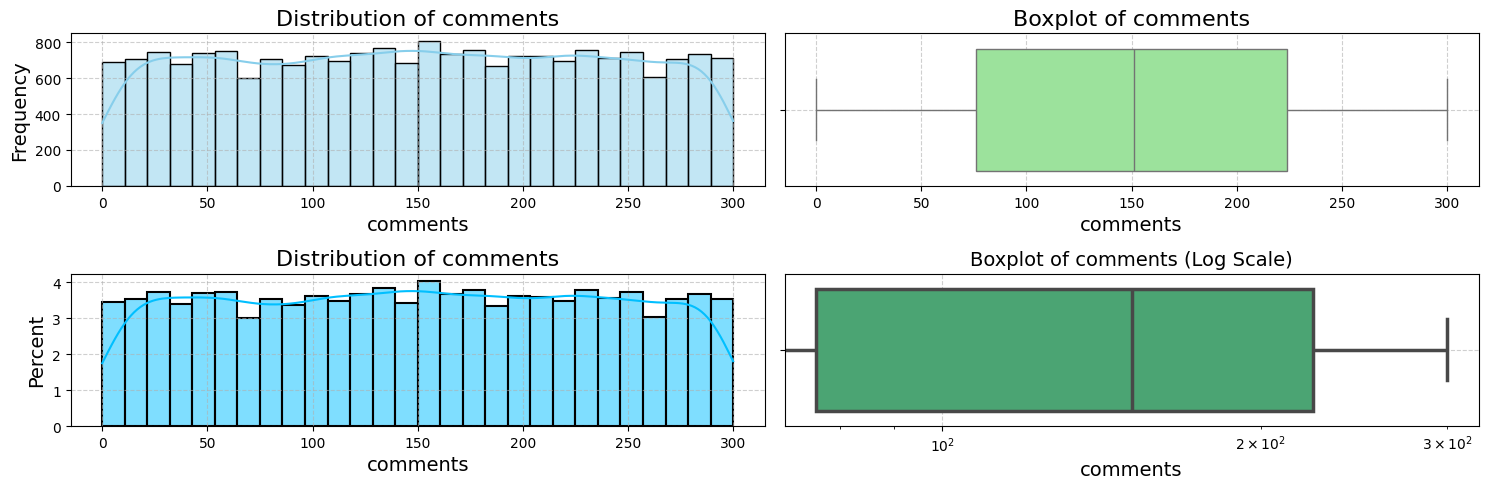

No missing values in comments.

Descriptive Statistics for share:
count    20000.000000
mean        49.655950
std         29.116266
min          0.000000
25%         25.000000
50%         50.000000
75%         75.000000
max        100.000000
Name: share, dtype: float64




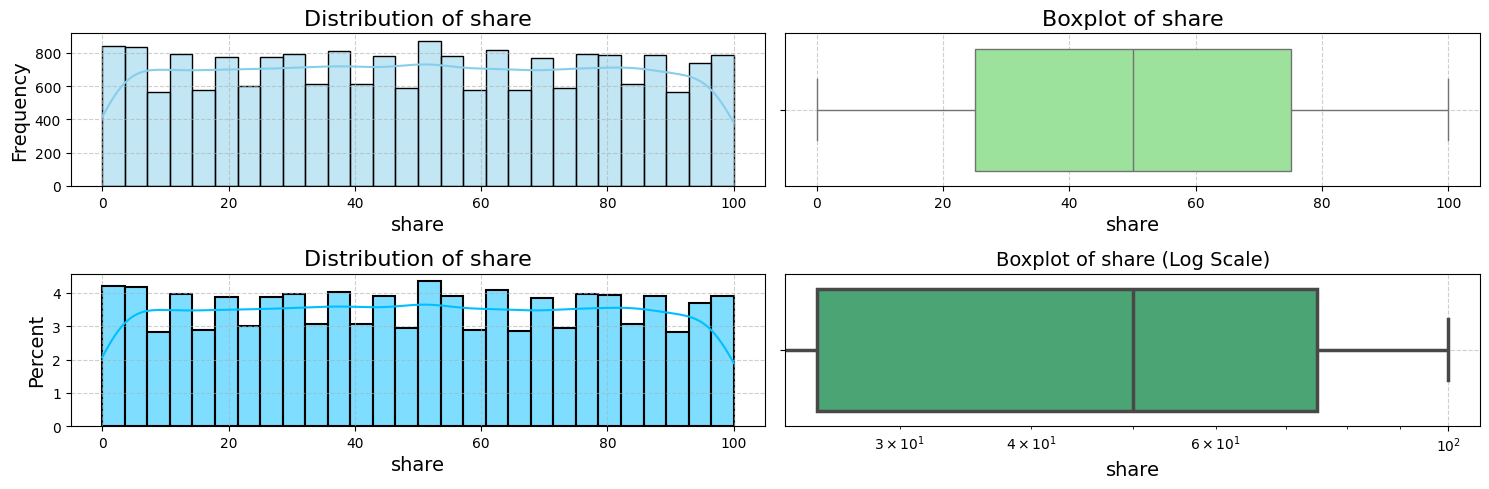

No missing values in share.

Descriptive Statistics for reaction:
count    20000.000000
mean       250.076750
std        144.919815
min          0.000000
25%        125.000000
50%        251.000000
75%        375.000000
max        500.000000
Name: reaction, dtype: float64




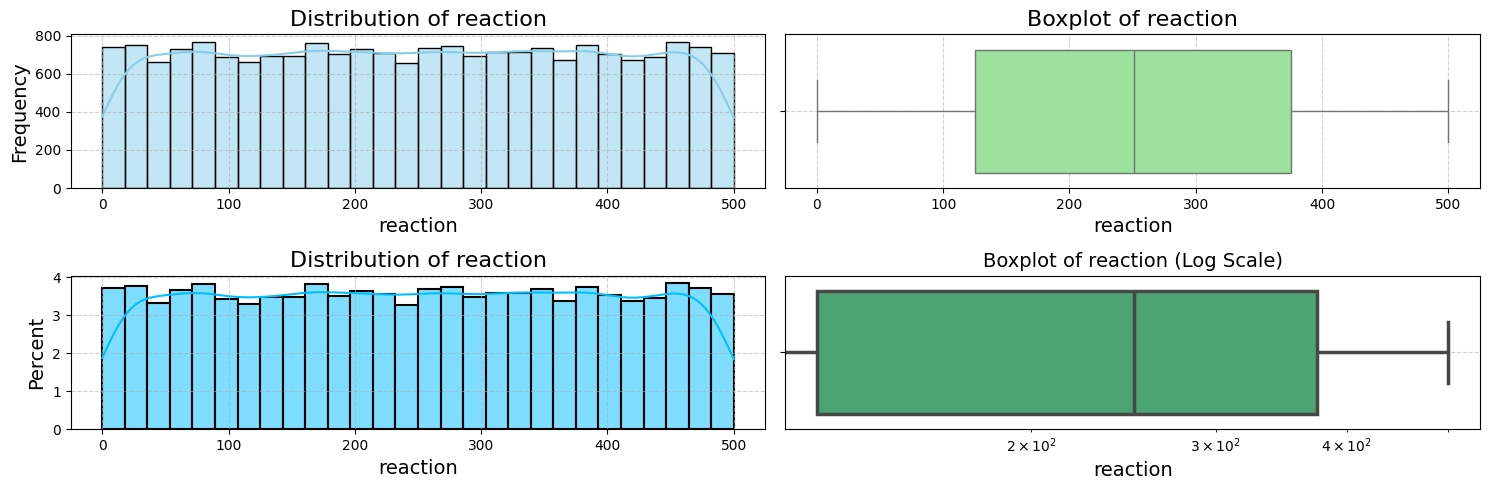

No missing values in reaction.



In [17]:
analyse_numerical_features(posts_df_cleaned_rows, cols_to_remove=["post_id"])

### Conclusion:

- No numerical features in `group_df`.
- `reach`: no values missing, no negative values, logarithmic distribution, big number of outliers with high values.
- `click`: no values missing, no negative values, logarithmic distribution, big number of outliers with high values.
- `likes`: 37 values missing, no negative values, logarithmic distribution, bit number of outliers with high values.
- `comments`: no values missing, rows count for each comments number is the almost same, no outliers.
- `share`: no values missing, rows count for each share number is the almost same, no outliers.
- `reaction`: no values missing, rows count for each reaction number is the almost same, no outliers.

## 6. Numerical features within group:

We will join `group_df` with `posts_df` and explore separately behaviour of each numerical feature within `group_name` and `post_type`.

In [18]:
posts_and_group_df = group_df_cleaned_rows.set_index("post_id").join(
    posts_df_cleaned_rows.set_index("post_id"), 
    on=["post_id"], 
    how="outer", 
    rsuffix="_group_df"
).reset_index()

In [19]:
posts_and_group_df

,post_id,group_name,post_date,post_type,reach,click,likes,comments,share,reaction
0,1,groupE,2024-01-10,article,848706,67896,59409.0,241,37,384
1,2,groupC,2024-02-06,short,7927,476,317.0,284,72,16
2,3,groupC,2024-01-18,short,8326,666,167.0,252,32,50
3,4,groupD,2024-02-11,short,4039,162,40.0,149,87,487
4,5,groupE,2024-03-13,promo,496568,39725,14897.0,57,7,271
...,...,...,...,...,...,...,...,...,...,...
19995,19996,groupB,2024-01-01,article,844,51,68.0,71,100,257
19996,19997,groupD,2024-01-14,short,4139,331,83.0,275,70,295
19997,19998,groupA,2024-01-15,article,457,41,18.0,155,71,281
19998,19999,groupC,2024-01-03,short,92,6,7.0,156,40,379


### Investigation:

Graphs displayed for category group_name: 



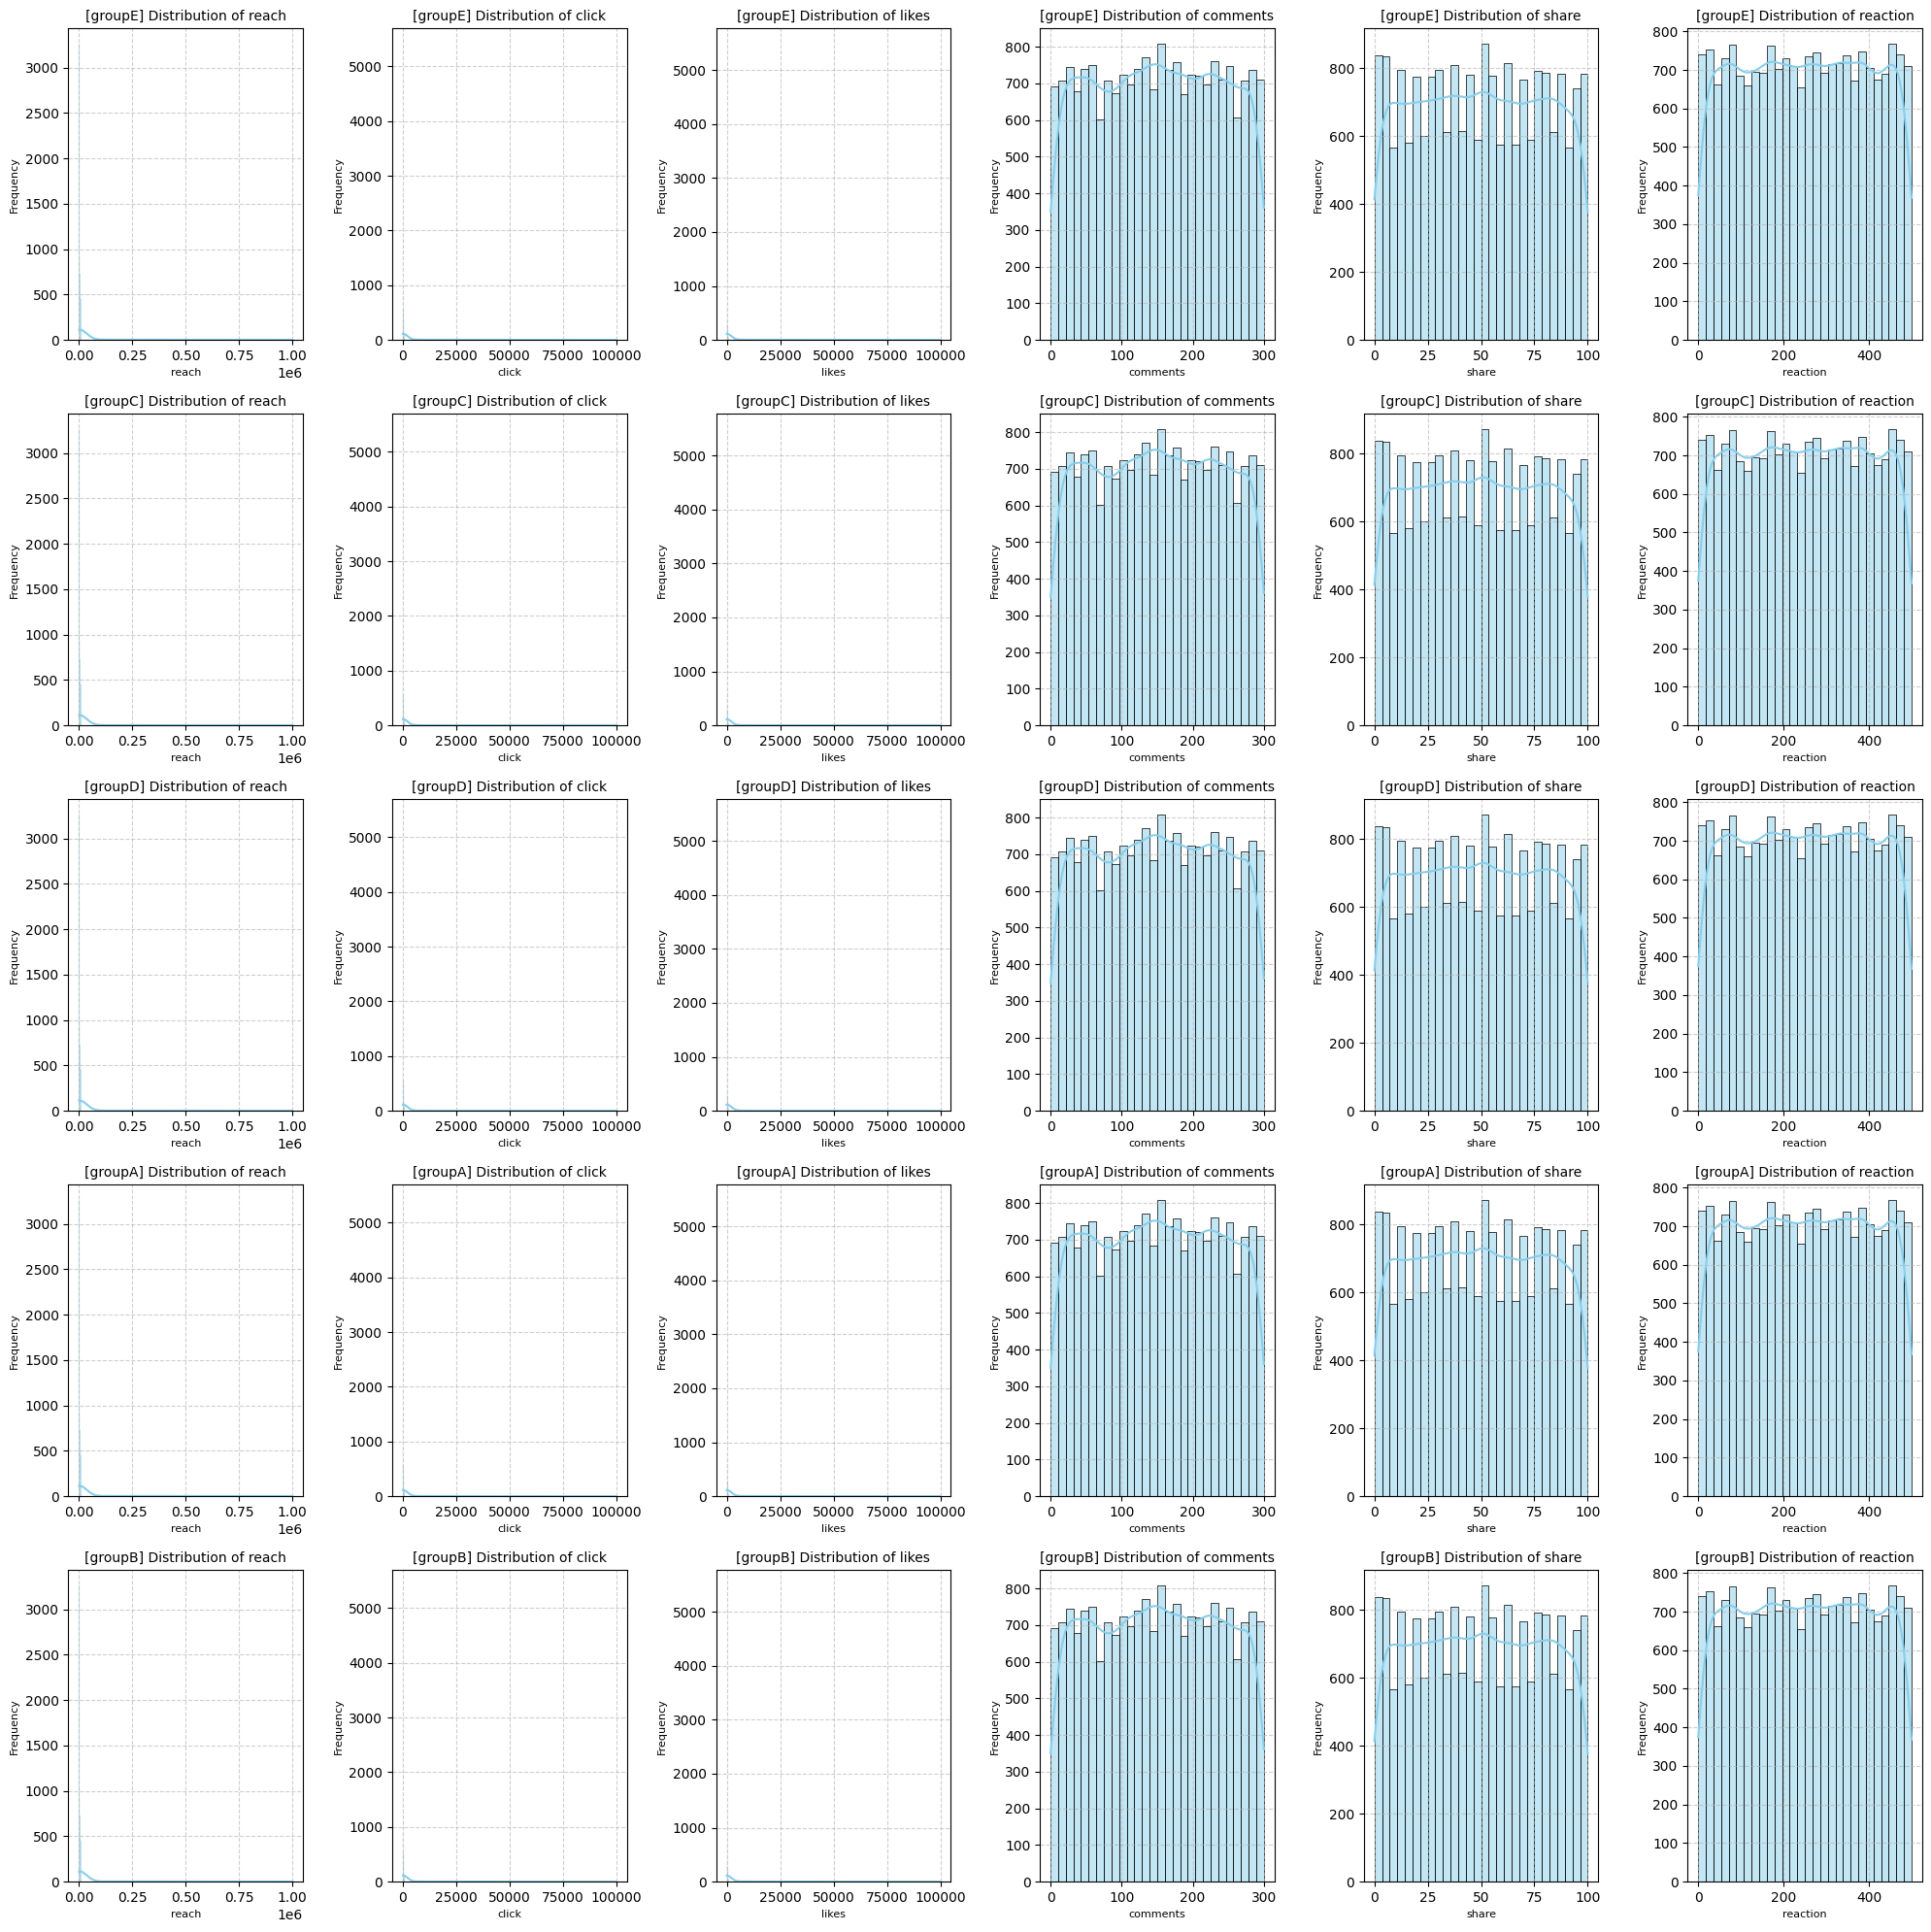

Graphs displayed for category post_type: 



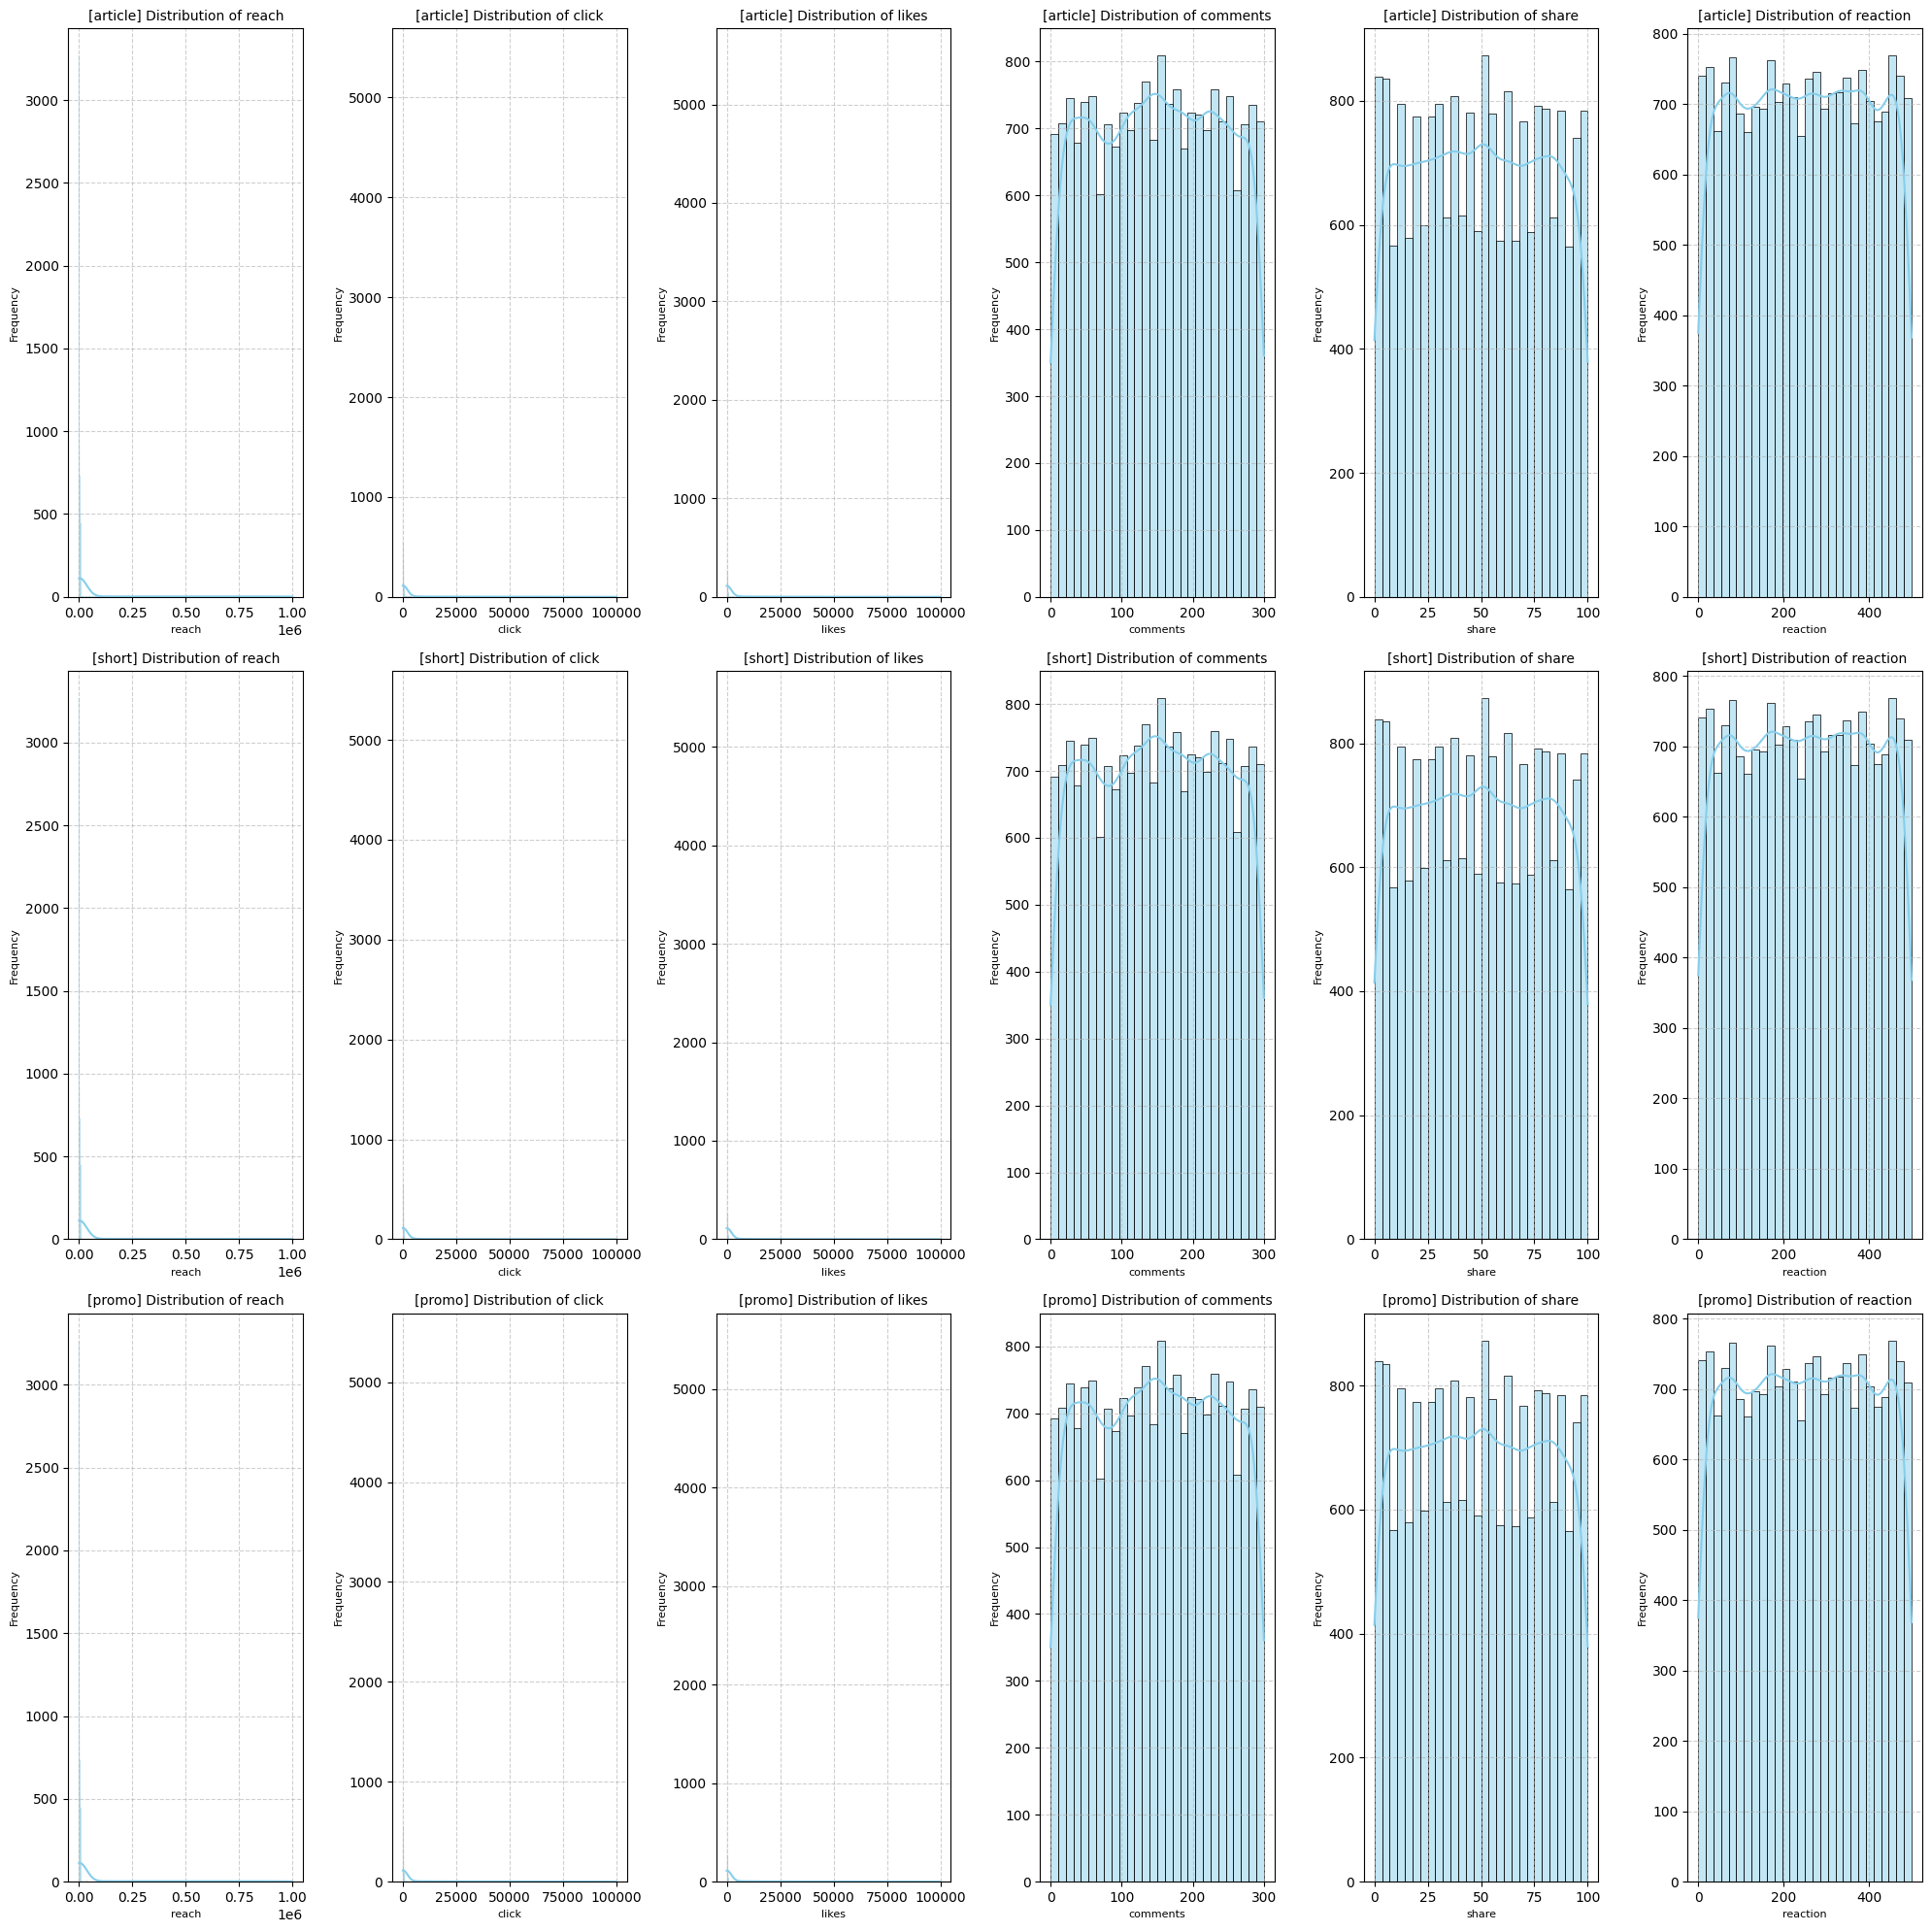

In [20]:
analyse_numerical_features_per_category(posts_and_group_df, ["post_id"])

### Conclusion:

As it could be seen from the graphics above, there are no significant differences between features distribution between groups, and all of them are simmilar to the global one. Therefore, any special insights depending on a group type can not be found.

## 7. Correlation between numerical features:

### Investigation:

Reviewing Pearson and Spearman correlation matrices between numerical features:

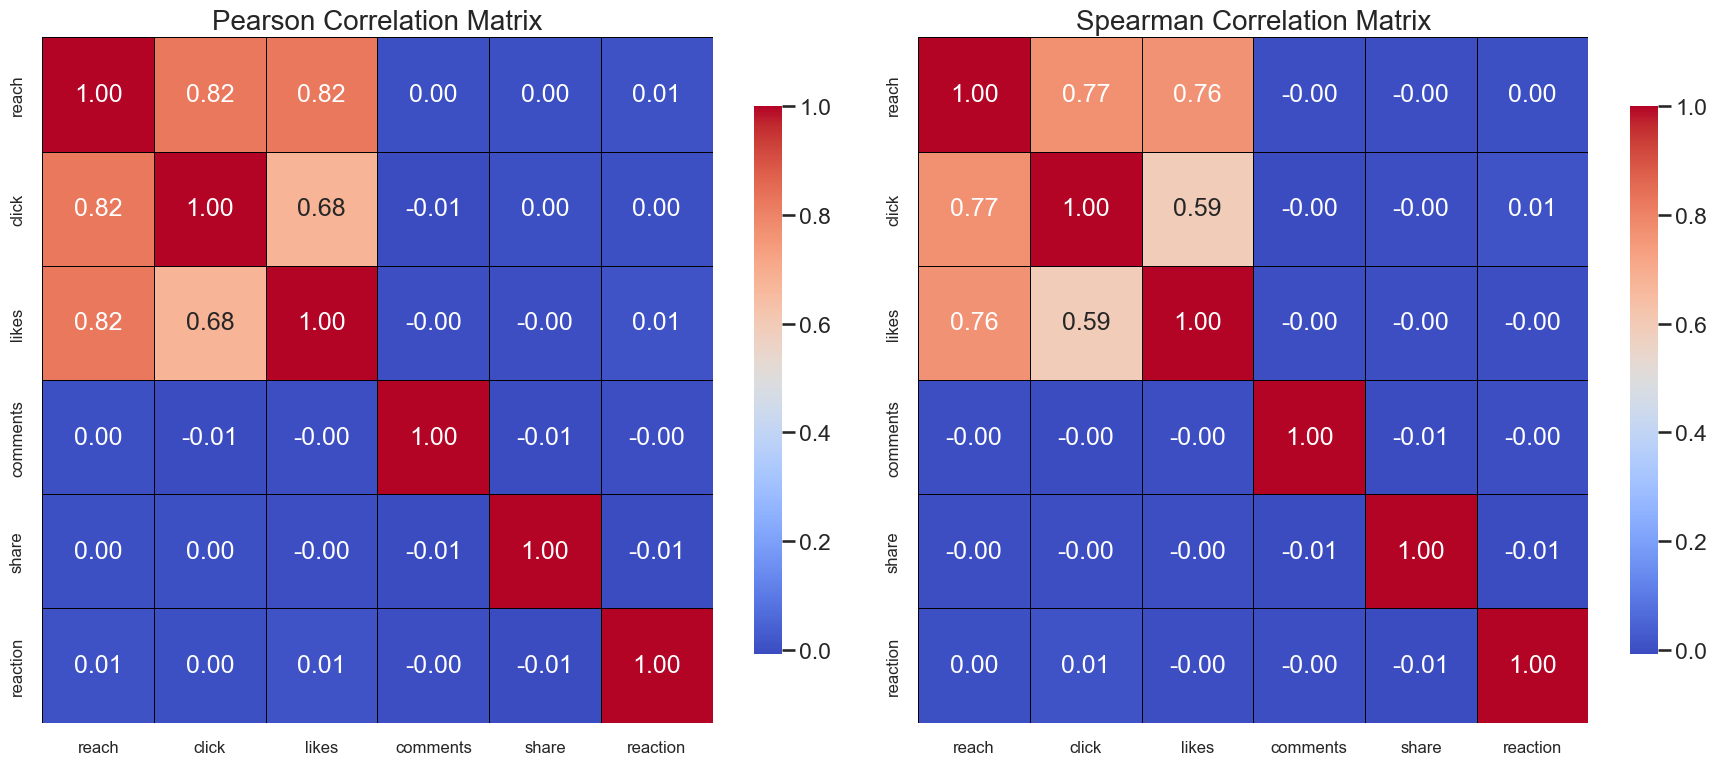

In [21]:
plot_correlation_matrices(posts_and_group_df, ["post_id"])

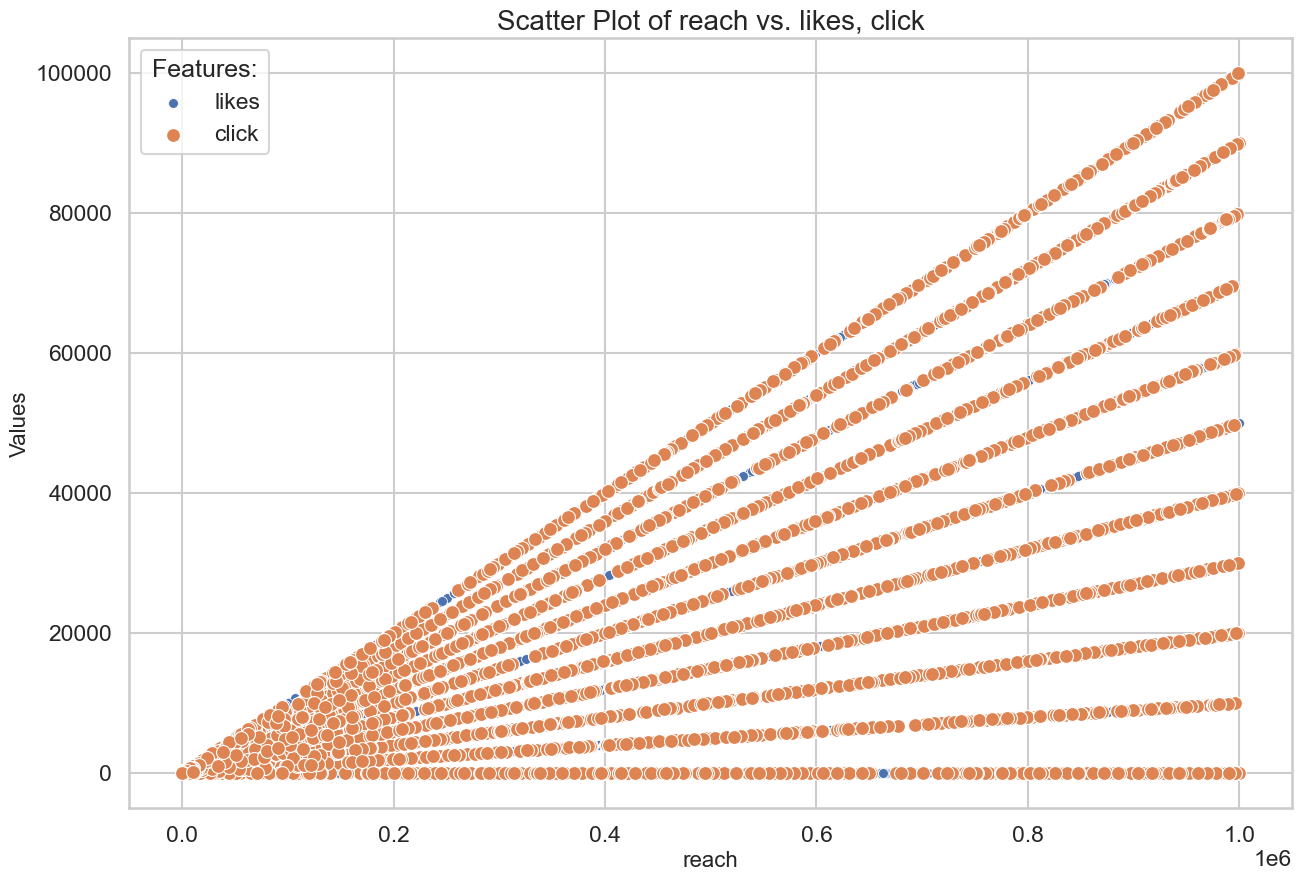

In [22]:
plot_scatter_graph(posts_and_group_df, "reach", ["likes", "click"])

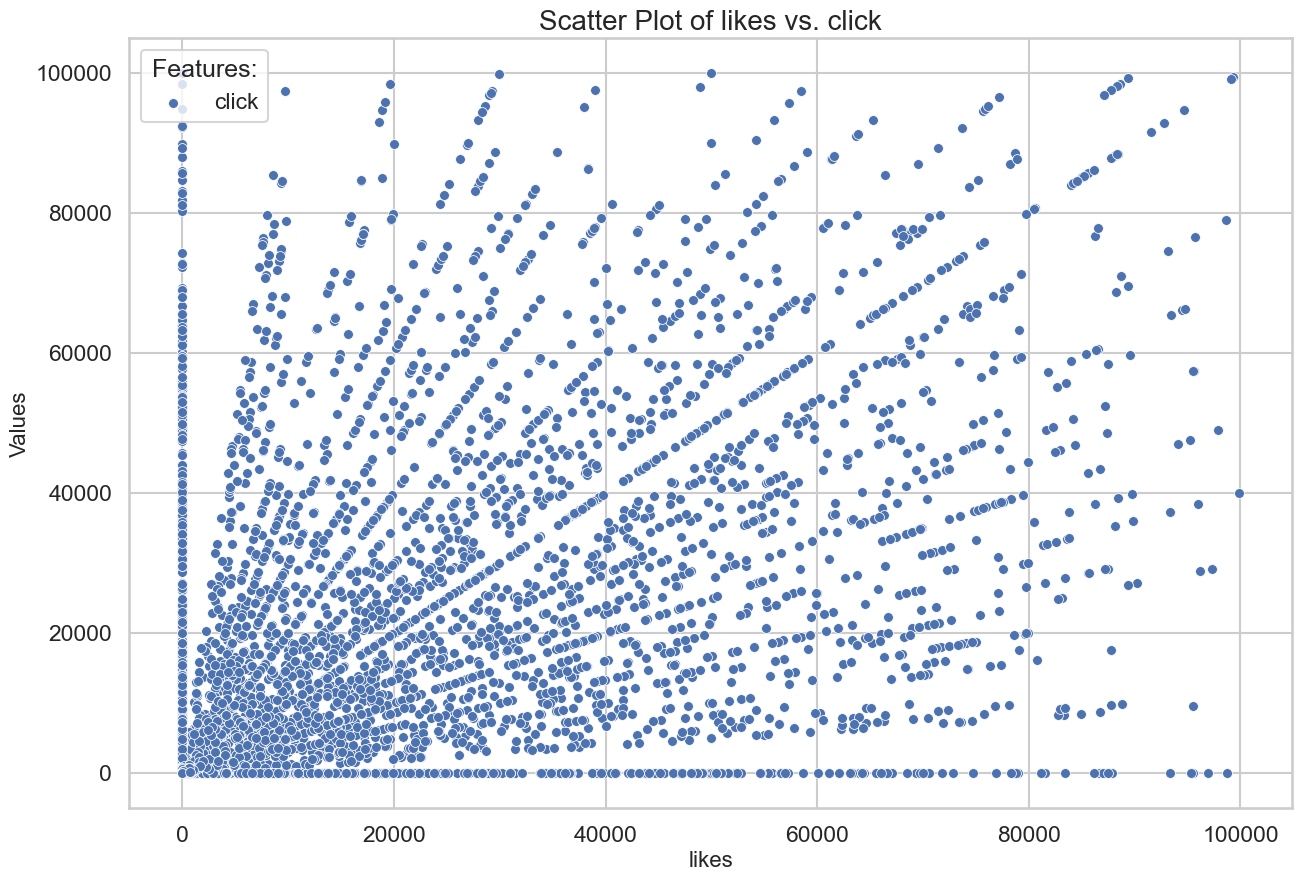

In [23]:
plot_scatter_graph(posts_and_group_df, "likes", ["click"])

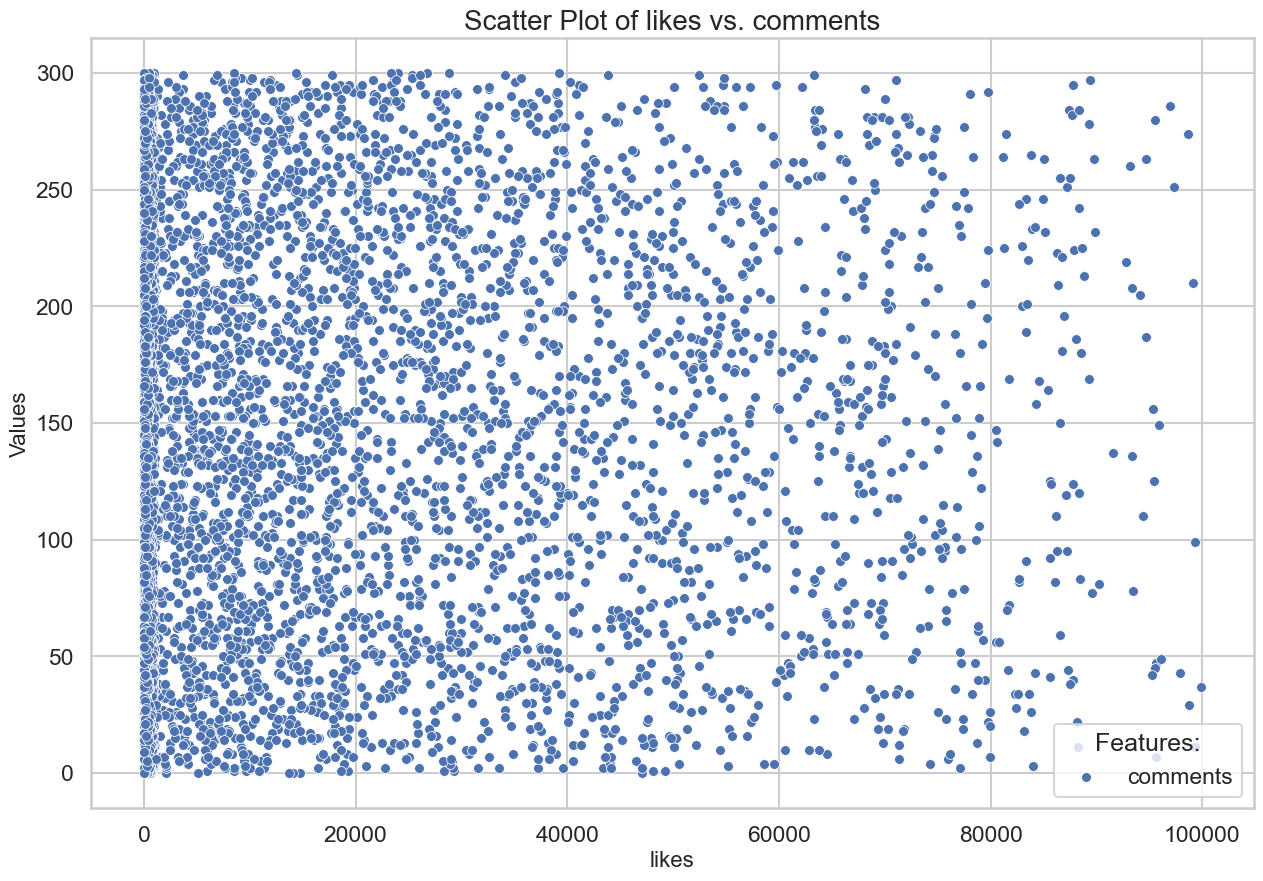

In [24]:
plot_scatter_graph(posts_and_group_df, "likes", ["comments"])

### Conclusion:

For `reach ~ likes` and `reach ~ clicks` exists a strong linear relationship. However, Spearman and Pearson difference in `0.05` could indicate that those features contain outliers and / or extreme values.

Strong linear relationship between mentioned features also tells us, that robust models (at least, we can start with linear regression) might preform well in futher predictive analysis.

In addition, relationships `reach ~ likes` and `reach ~ click` have form of 
$$
    \text{reach} = \alpha_i \cdot \text{likes}, \; i = \overline{0, 10},
$$
$$
    \text{reach} = \beta_i \cdot \text{click}, \; i = \overline{0, 10}.
$$
It is not the first consideration (not necesserily but) indicating that data was "a little bit" generated :).

## 8. Empty values handling:

### Investigation:

Since only one feature (`likes`) has 37 empty values, at first we will review this data:

In [25]:
posts_and_group_df[posts_and_group_df['likes'].isna()]

,post_id,group_name,post_date,post_type,reach,click,likes,comments,share,reaction
247,248,groupD,2024-03-21,promo,8961,627,NaN,220,25,310
1493,1494,groupA,2024-01-18,short,518,52,NaN,88,55,192
4281,4282,groupD,2024-02-08,article,8745,350,NaN,249,70,1
4542,4543,groupE,2024-03-20,article,790217,39511,NaN,155,73,107
4787,4788,groupA,2024-03-24,short,555,6,NaN,165,34,209
5044,5045,groupD,2024-01-07,short,7520,526,NaN,204,3,392
5103,5104,groupB,2024-03-03,article,2764,0,NaN,258,22,301
5304,5305,groupA,2024-03-27,article,135,3,NaN,206,5,282
5491,5492,groupC,2024-01-19,article,1957,78,NaN,195,19,280
6211,6212,groupD,2024-03-13,promo,6385,255,NaN,196,34,40


As we can see, missing `likes` are spread around distinct categories and posts where `reach`, `comments` and `share` vary a lot. Taking in consideration specific linear correlation (multiple lines in fact) `likes ~ reach`, the most reasonable approach of handling those empty values can be linear regression. In this case, missing `likes` would be on the "line in the middle".

In [26]:
posts_and_group_df_filled_missing_values = predict_missing_values_with_linear_regression(posts_and_group_df, 'reach', 'likes', 'likes_predicted_w_lr')

In [27]:
posts_and_group_df_filled_missing_values[posts_and_group_df_filled_missing_values["likes_predicted_w_lr"] == True]

,post_id,group_name,post_date,post_type,reach,click,likes,comments,share,reaction,likes_predicted_w_lr
247,248,groupD,2024-03-21,promo,8961,627,450,220,25,310,True
1493,1494,groupA,2024-01-18,short,518,52,26,88,55,192,True
4281,4282,groupD,2024-02-08,article,8745,350,440,249,70,1,True
4542,4543,groupE,2024-03-20,article,790217,39511,39723,155,73,107,True
4787,4788,groupA,2024-03-24,short,555,6,28,165,34,209,True
5044,5045,groupD,2024-01-07,short,7520,526,378,204,3,392,True
5103,5104,groupB,2024-03-03,article,2764,0,139,258,22,301,True
5304,5305,groupA,2024-03-27,article,135,3,7,206,5,282,True
5491,5492,groupC,2024-01-19,article,1957,78,98,195,19,280,True
6211,6212,groupD,2024-03-13,promo,6385,255,321,196,34,40,True


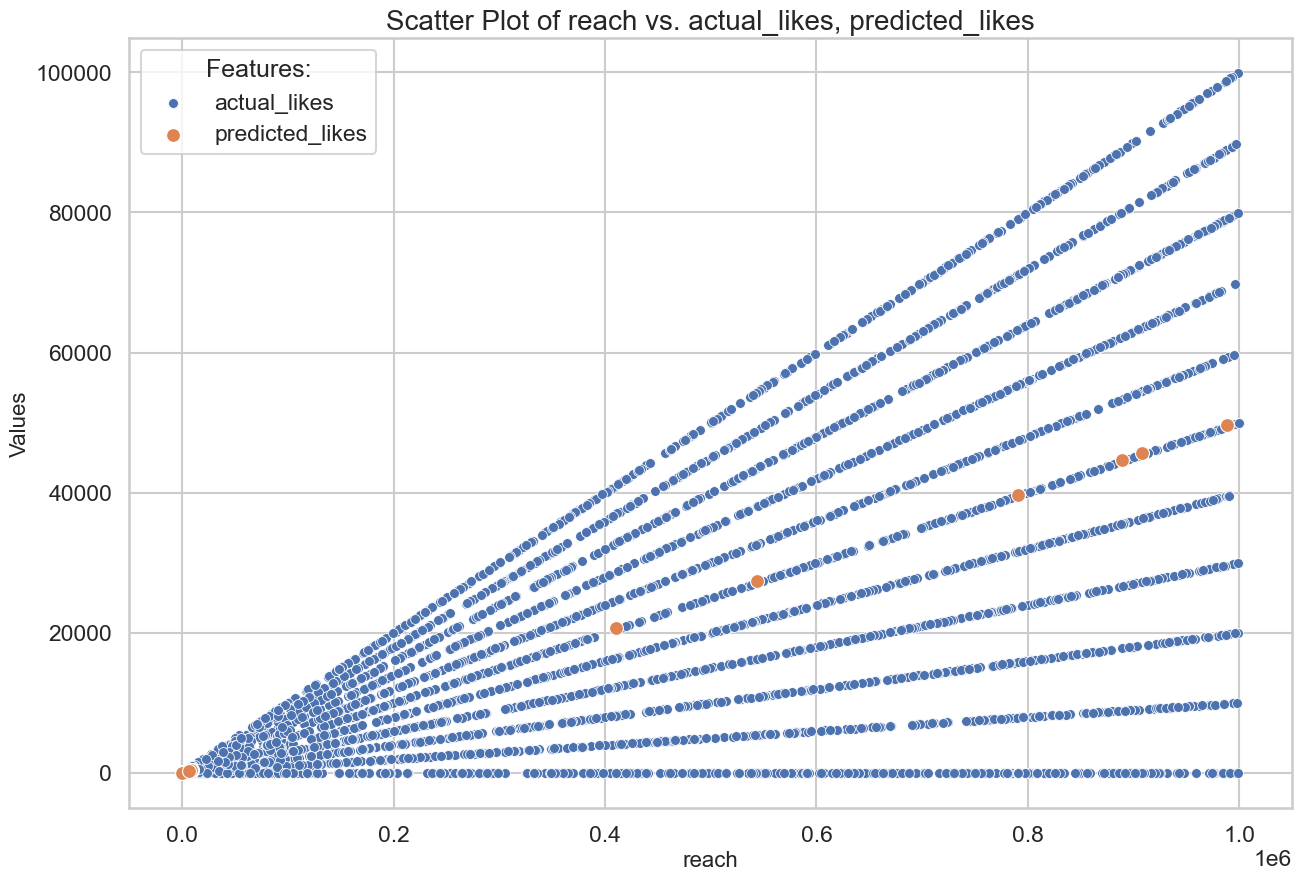

In [28]:
df_splitted_likes = posts_and_group_df_filled_missing_values[["reach", "likes", "likes_predicted_w_lr"]]
df_splitted_likes["predicted_likes"] = np.where(df_splitted_likes["likes_predicted_w_lr"], df_splitted_likes["likes"], None)
df_splitted_likes["actual_likes"] = np.where(~df_splitted_likes["likes_predicted_w_lr"], df_splitted_likes["likes"], None)

plot_scatter_graph(df_splitted_likes, "reach", ["actual_likes", "predicted_likes"])

### Conclusion:

Since data is kinda synthetic and no significant correlation except `reach ~ likes` exists, linear regression for 37 empty likes population can give a meaningful "average" values without necessity to exclude those rows from analysis.

## 9. Outliers analysis and handling:

### Inestigation:

From numerical feature analysis we can conclude, that outliers and any possible anomalies are in features `reach`, `likes` and `click`. Now we will take a look at total number and data of outliers per each feature.

In [29]:
reach_outliers = get_outliers_IRQ(posts_and_group_df_filled_missing_values, "reach")
likes_outliers = get_outliers_IRQ(posts_and_group_df_filled_missing_values, "likes")
click_outliers = get_outliers_IRQ(posts_and_group_df_filled_missing_values, "click")

Number of outliers in 'reach': 3967
Outliers statistics:
count      3967.000000
mean     514307.745652
std      282995.188409
min       20937.000000
25%      268513.500000
50%      516023.000000
75%      763542.500000
max      999755.000000
Name: reach, dtype: float64
Number of outliers in 'likes': 3573
Outliers statistics:
count     3573.000000
mean     28712.371397
std      22907.830673
min       1193.000000
25%       9577.000000
50%      22153.000000
75%      42930.000000
max      99869.000000
Name: likes, dtype: float64
Number of outliers in 'click': 3575
Outliers statistics:
count     3575.000000
mean     28392.148252
std      23005.056095
min       1193.000000
25%       9351.500000
50%      21465.000000
75%      41755.500000
max      99923.000000
Name: click, dtype: float64


In [30]:
reach_outliers

,post_id,group_name,post_date,post_type,reach,click,likes,comments,share,reaction,likes_predicted_w_lr
0,1,groupE,2024-01-10,article,848706,67896,59409,241,37,384,False
4,5,groupE,2024-03-13,promo,496568,39725,14897,57,7,271,False
11,12,groupE,2024-02-11,short,210466,16837,6314,102,34,81,False
15,16,groupE,2024-02-17,short,722844,65056,50599,4,84,441,False
22,23,groupE,2024-03-21,short,191904,1919,7676,97,90,174,False
...,...,...,...,...,...,...,...,...,...,...,...
19983,19984,groupE,2024-02-03,article,795994,79599,71639,85,84,158,False
19984,19985,groupE,2024-03-27,short,301519,3015,15076,166,62,21,False
19985,19986,groupE,2024-02-11,short,415171,0,4152,276,4,266,False
19991,19992,groupE,2024-02-16,promo,717653,71765,43059,102,43,298,False


In [31]:
click_outliers

,post_id,group_name,post_date,post_type,reach,click,likes,comments,share,reaction,likes_predicted_w_lr
0,1,groupE,2024-01-10,article,848706,67896,59409,241,37,384,False
4,5,groupE,2024-03-13,promo,496568,39725,14897,57,7,271,False
11,12,groupE,2024-02-11,short,210466,16837,6314,102,34,81,False
15,16,groupE,2024-02-17,short,722844,65056,50599,4,84,441,False
22,23,groupE,2024-03-21,short,191904,1919,7676,97,90,174,False
...,...,...,...,...,...,...,...,...,...,...,...
19979,19980,groupE,2024-02-01,promo,819790,49187,32792,139,25,7,False
19983,19984,groupE,2024-02-03,article,795994,79599,71639,85,84,158,False
19984,19985,groupE,2024-03-27,short,301519,3015,15076,166,62,21,False
19991,19992,groupE,2024-02-16,promo,717653,71765,43059,102,43,298,False


In [32]:
likes_outliers

,post_id,group_name,post_date,post_type,reach,click,likes,comments,share,reaction,likes_predicted_w_lr
0,1,groupE,2024-01-10,article,848706,67896,59409,241,37,384,False
4,5,groupE,2024-03-13,promo,496568,39725,14897,57,7,271,False
11,12,groupE,2024-02-11,short,210466,16837,6314,102,34,81,False
15,16,groupE,2024-02-17,short,722844,65056,50599,4,84,441,False
22,23,groupE,2024-03-21,short,191904,1919,7676,97,90,174,False
...,...,...,...,...,...,...,...,...,...,...,...
19983,19984,groupE,2024-02-03,article,795994,79599,71639,85,84,158,False
19984,19985,groupE,2024-03-27,short,301519,3015,15076,166,62,21,False
19985,19986,groupE,2024-02-11,short,415171,0,4152,276,4,266,False
19991,19992,groupE,2024-02-16,promo,717653,71765,43059,102,43,298,False


Most rows in 3 outliers dataset are the same, and it could be a thing, that outliers detected with IRQ are actually outstanding and the most popular posts within whole dataset. Therefore, we do not need to exclude those rows from futher consideration as they are priceless examples of posts success.

On the other hand, it is interesting to look at rows, where only one or two considered features have extremely high values.

In [33]:
out1, out2, out3 = get_distinct_rows_from_dataframes([reach_outliers, likes_outliers, click_outliers])

In [34]:
out1 # reach

,post_id,group_name,post_date,post_type,reach,click,likes,comments,share,reaction,likes_predicted_w_lr
685,686,groupE,2024-01-11,short,88183,882,0,261,72,195,False
976,977,groupE,2024-01-17,article,28103,562,562,114,80,10,False
1205,1206,groupE,2024-01-24,short,57112,1142,1142,179,47,381,False
1402,1403,groupE,2024-01-27,article,125439,0,0,18,32,111,False
1631,1632,groupE,2024-01-11,article,24541,0,0,19,77,435,False
2292,2293,groupE,2024-01-02,article,406350,0,0,225,66,425,False
2668,2669,groupE,2024-01-04,promo,607136,0,0,297,42,418,False
2725,2726,groupE,2024-03-31,short,173901,0,0,27,70,378,False
3000,3001,groupE,2024-01-28,short,37147,371,0,288,14,1,False
3195,3196,groupE,2024-02-14,short,21467,429,0,11,31,471,False


In [35]:
out2 # likes

,post_id,group_name,post_date,post_type,reach,click,likes,comments,share,reaction,likes_predicted_w_lr
3528,3529,groupE,2024-03-16,short,17954,1077,1795,113,99,444,False
4804,4805,groupE,2024-02-20,short,16739,335,1507,241,52,16,False
5495,5496,groupE,2024-03-09,article,20177,404,2018,32,54,444,False
6411,6412,groupE,2024-03-27,short,15316,0,1532,158,43,70,False
8174,8175,groupE,2024-03-30,short,18461,923,1661,67,74,169,False
11812,11813,groupE,2024-03-14,article,14192,284,1277,177,74,143,False
12139,12140,groupE,2024-03-02,short,12776,511,1278,268,92,12,False
12638,12639,groupE,2024-01-17,short,17203,0,1204,63,67,337,False
18149,18150,groupE,2024-02-04,promo,16140,807,1291,104,98,15,False
18422,18423,groupE,2024-01-16,promo,15320,766,1532,121,81,427,False


In [36]:
out3 # click

,post_id,group_name,post_date,post_type,reach,click,likes,comments,share,reaction,likes_predicted_w_lr
386,387,groupE,2024-01-07,short,16393,1639,164,223,39,268,False
408,409,groupE,2024-01-19,promo,19608,1569,1176,207,23,466,False
457,458,groupE,2024-03-24,short,18196,1820,364,46,0,20,False
578,579,groupE,2024-03-27,promo,19165,1342,1150,43,92,448,False
2083,2084,groupE,2024-03-11,article,12234,1223,979,218,52,252,False
6841,6842,groupE,2024-01-11,promo,17936,1614,897,290,69,325,False
7644,7645,groupE,2024-02-18,short,18581,1858,0,210,36,386,False
13666,13667,groupE,2024-03-23,promo,19891,1392,796,281,67,303,False
16693,16694,groupE,2024-01-27,article,15643,1251,0,87,97,187,False
16973,16974,groupE,2024-01-14,short,18343,1834,734,254,75,426,False


### Conclusion:

Rows, which were considered as outliers by IRQ for all 3 features, we will keep in the dataset, as they are "examples of post success", required for futher analysis.

Other cases are the following:
- High `reach`, high `likes`, relatively small amount of `clicks`: _those rows are indicating that something is wrong with data (we suppose that `clicks` presents a total amount of clicks on the post, including likes / comments / sharing functionality), and, therefore, they would be excluded from analysis._
- High `reach`, relatively small amount of `likes`, high `clicks`: _keeping these rows in analysis, as they could indicate that posts were seen buy big amount of users, but collected negative reactions._
- High `reach`, small amount of `likes` and `clicks`: _keeping these rows in analysis as posts, that were seen buy big amount of people, but did not force them to interact with this post._

## 10. Common sence questions:

In this part data would be analysed from "domain-specific perspective", with following assumptions applied:

1. Feature `clicks` captures total amount of clicks and interaction with a post by users reached it, including likes / sharing / commenting functionalities.
3. `post_date` can not be in future or way to early.

With this consideration, following rules must be applied:
1. Number of `clicks` must be greater than sum of `likes`, `comments`, `reaction`, and `share`.
2. Number of `reach` can not be lower than number of `clicks`.
3. `post_date` can not be earlier the the 30-th of April 1991 (date of first web-site creation: https://en.wikipedia.org/wiki/List_of_websites_founded_before_1995), and can not be later than the 17th of February 2025.

### Investigation: 

In [37]:
posts_and_group_df_filled_missing_values[
    posts_and_group_df_filled_missing_values["click"] >= (
        posts_and_group_df_filled_missing_values["likes"] + 
        posts_and_group_df_filled_missing_values["comments"] + 
        posts_and_group_df_filled_missing_values["reaction"] + 
        posts_and_group_df_filled_missing_values["share"]
    )
]

,post_id,group_name,post_date,post_type,reach,click,likes,comments,share,reaction,likes_predicted_w_lr
0,1,groupE,2024-01-10,article,848706,67896,59409,241,37,384,False
2,3,groupC,2024-01-18,short,8326,666,167,252,32,50,False
4,5,groupE,2024-03-13,promo,496568,39725,14897,57,7,271,False
11,12,groupE,2024-02-11,short,210466,16837,6314,102,34,81,False
15,16,groupE,2024-02-17,short,722844,65056,50599,4,84,441,False
...,...,...,...,...,...,...,...,...,...,...,...
19939,19940,groupE,2024-03-13,short,908770,45438,36351,191,0,366,False
19963,19964,groupE,2024-01-03,short,127836,12784,8949,76,99,377,False
19979,19980,groupE,2024-02-01,promo,819790,49187,32792,139,25,7,False
19983,19984,groupE,2024-02-03,article,795994,79599,71639,85,84,158,False


There are only 2'428 rows out of 20'000, that satisfy criteria no. 1. It seems, that our assumption was wrong and `click` metric
does not include other interactions with post, captured by other features.

In [38]:
posts_and_group_df_filled_missing_values[
    posts_and_group_df_filled_missing_values["reach"] >= posts_and_group_df_filled_missing_values["click"]
]

,post_id,group_name,post_date,post_type,reach,click,likes,comments,share,reaction,likes_predicted_w_lr
0,1,groupE,2024-01-10,article,848706,67896,59409,241,37,384,False
1,2,groupC,2024-02-06,short,7927,476,317,284,72,16,False
2,3,groupC,2024-01-18,short,8326,666,167,252,32,50,False
3,4,groupD,2024-02-11,short,4039,162,40,149,87,487,False
4,5,groupE,2024-03-13,promo,496568,39725,14897,57,7,271,False
...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,groupB,2024-01-01,article,844,51,68,71,100,257,False
19996,19997,groupD,2024-01-14,short,4139,331,83,275,70,295,False
19997,19998,groupA,2024-01-15,article,457,41,18,155,71,281,False
19998,19999,groupC,2024-01-03,short,92,6,7,156,40,379,False


All rows satisfy criteria no. 2, so we are fine here.

In [39]:
posts_and_group_df_filled_missing_values["post_date"].describe()

count                         20000
mean     2024-02-15 01:02:03.840000
min             2024-01-01 00:00:00
25%             2024-01-23 00:00:00
50%             2024-02-15 00:00:00
75%             2024-03-09 00:00:00
max             2024-03-31 00:00:00
Name: post_date, dtype: object

All rows satisfy criteria no. 3.

### Conclusion:

As we saw, feature `clicks` likely does not necesserily captures `likes`, `share` and other interactions with post. Other obvious data inconsistencies are absent.

## Saving processed data to _Silver Layer_:

Now preprocessed and cleaned data is saved to _silver layer_, ready to be analysed later.

In [40]:
save_dataset(posts_and_group_df_filled_missing_values, SILVER_PATH + "posts_and_group.parquet")